In [1]:
# Загрузим все нужные библиотеки
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import datetime as dt

# 1. Построение выборки.

## 1.1. Загрузка и предварительный анализ выборки в DataFrame формате

In [151]:
df=pd.read_csv('./query_result_2019-12-24T07_29_06.659397Z.csv', engine = 'python', sep="," , encoding = 'utf-8'
                       )

In [152]:
df

Time End          Time End Local Tz  Time Offset  \
0      2019-05-05T09:40:00+03:00  2019-05-05T12:40:00+03:00        10800   
1      2019-05-05T11:13:29+03:00  2019-05-05T14:13:29+03:00        10800   
2      2019-05-05T12:07:42+03:00  2019-05-05T15:07:42+03:00        10800   
3      2019-05-05T13:04:05+03:00  2019-05-05T16:04:05+03:00        10800   
4      2019-05-05T13:18:18+03:00  2019-05-05T16:18:18+03:00        10800   
...                          ...                        ...          ...   
39666  2019-06-30T19:11:32+03:00  2019-06-30T22:11:32+03:00        10800   
39667  2019-06-30T19:12:19+03:00  2019-06-30T22:12:19+03:00        10800   
39668  2019-06-30T19:13:07+03:00  2019-06-30T22:13:07+03:00        10800   
39669  2019-06-30T19:33:06+03:00  2019-06-30T22:33:06+03:00        10800   
39670  2019-06-30T19:33:19+03:00  2019-06-30T22:33:19+03:00        10800   

                      Time Start        Time Start Local Tz  User ID  Value  
0      2019-05-05T09:39:59+03:00  2019-05-05T12:39:59+03:00     2166    1.0  
1      2019-05-05T11:12:51+03:00  2019-05-05T14:12:51+03:00     2166   34.0  
2      2019-05-05T12:07:39+03:00  2019-05-05T15:07:39+03:00     2166    1.0  
3      2019-05-05T13:04:02+03:00  2019-05-05T16:04:02+03:00     2166    3.0  
4      2019-05-05T13:18:13+03:00  2019-05-05T16:18:13+03:00     2166    6.0  
...                          ...                        ...      ...    ...  
39666  2019-06-30T19:10:34+03:00  2019-06-30T22:10:34+03:00     2166   85.0  
39667  2019-06-30T19:11:32+03:00  2019-06-30T22:11:32+03:00     2166   64.0  
39668  2019-06-30T19:13:05+03:00  2019-06-30T22:13:05+03:00     2166    1.0  
39669  2019-06-30T19:30:00+03:00  2019-06-30T22:30:00+03:00     2166   13.0  
39670  2019-06-30T19:33:06+03:00  2019-06-30T22:33:06+03:00     2166    9.0  

[39671 rows x 7 columns]

In [153]:
df.describe()

Time Offset  User ID         Value
count  39671.000000  39671.0  39671.000000
mean   10465.599556   2166.0     39.936024
std     1045.009793      0.0    129.078392
min     7200.000000   2166.0      1.000000
25%    10800.000000   2166.0      4.000000
50%    10800.000000   2166.0      8.000000
75%    10800.000000   2166.0     49.000000
max    10800.000000   2166.0  13508.000000

### Итак у нас есть 7 колонок:

1. Time end/start - время начала и конца мониторинга трекера в том числе и для локального часового пояса.
2. Time offset - длина мониторинга треккера присутствуют два значения 7200 и 10800, что соотвествует продолжительности мониторинга 2 и 3 часа соотвественно. Общее число замеров длиной 2 часа составляет-9,2 процента от всех замеров за 3 месяца.
3. User_ID - один пользователь
4. Value - предположительно количество шагов

### Первые шаги по обработке данных:

1. Извлечь длину временного окна и использовать ее как вещественную переменную для связи с числом шагов - колонка 'Difference'
2. Попробывать найти интерпретацию переменной time offset  и нормализовать переменную value(посмотреть тип распределения и если требуется провести очистку данных)
3. Извлечь дни недели и использавать для кодированиея среднем числом шагов по дням - колонки 'hour mean' и 'date mean'
4. Извлечь часы и посмотреть распределение шагов в течении дня
5. Попробывать найти интерпретацию переменной time offset  и нормализовать переменную value(посмотреть тип распределения и если требуется провести очистку данных)

In [154]:
###переводим колонки в datetime формат
df['Time End'] = pd.to_datetime(df['Time End'], infer_datetime_format=True, dayfirst=True)
df['Time Start'] = pd.to_datetime(df['Time Start'], infer_datetime_format=True, dayfirst=True)
df['Difference'] = df['Time End'] - df['Time Start']
df['Difference'] = df['Difference'] / np.timedelta64(1, 's')
###убираем ненужные колонки
df.set_index('Time Start', inplace=True)
df.drop(['Time End Local Tz', 'Time Start Local Tz'], axis=1, inplace=True)
###Извлекаем из времени категориальные переменные (год, месяц, дата, час, время)
df['year'] = df.index.strftime('%Y')
df['month'] = df.index.strftime('%b')
df['date'] = df.index.strftime('%d')
df['hour'] = df.index.strftime('%H')
df['Day_of_week'] = df.index.strftime('%a')
df['Day_of_week_num'] = df.index.strftime('%u')
###Приводим к корректным типам данных и создаем колонку номера наблюдения нашего трекера
df['Day_of_week_num'] = df['Day_of_week_num'].astype(int)
df['Value']=df['Value'].astype(int)
df['num_of_observations']=np.arange(len(df))


In [14]:
pandas_profiling.ProfileReport(df)

### Предварительные выводы касательно структуры данных переменных:

1. Day_of_week - чуть меньше половины всех наблюдений приходиться на временной интервал длиной 3 дня "Воскресенье-Вторник". Следует деталньо проанализировать этот факт при построение временного ряда, т.к. возможно это поможет выявить цикличность данных.
2. Difference, Value - Распределния обоих эти величин сильно скошены (позитивно, т.е. значение среднего будет больше медианы и моды). Матрица корелляций Пирсона показывает что эти две переменные сильно кореллированы между собой, т.е. продолжительность временного окна работы трекера и количество шагов могут иметь линейную зависимость, что абсолютно не укладывается в логику работы треккера (1 шаг в 1 секунду это неадекватность).Таким образом если мы не будем "очищать" наши данные от выбросов (1 шаг ) и "нерелеватных" значений(время работы равное 1 секунде), то использовать среднее как оценку мы не сможем. Так же при анализе временного ряда следует обратить внимания на экстремальные значения, их периодичность и длину временного окна
3. Hour - ~35% всех наблюдений относятся к временному интервалу длиной 3 часа "17-19". Это факт, в совокупности с п.2 позволит отфильтровать нашу выборку оставив только "релеватные" (отображающие реальное поведение пользователя) значения.

1. Создадим подвыборку df_cleaned на основе полученных нами статистических критериев.
2. В качестве фильтров для поля "Difference" нижней границей назначим значение равное 75% квартилю(Q3)-59 секунд, а верхней грациней значение равное 10 минутам работы (600 секунд)
3. В качестве фильтров для поля "Value" нижней границей назначим значение равное 75% квартилю(Q3)-49 шагов, а верхняя граница нам не понадобиться т.к. ее роль на себя берет граница поля difference.

In [167]:
df_cleaned = df[(df["Difference"]<600)&(df["Value"]>49)&(df["Difference"]>59)]
df_cleaned

Time End  Time Offset  User ID  \
Time Start                                                                  
2019-05-05 14:58:09+03:00 2019-05-05 14:59:59+03:00        10800     2166   
2019-06-05 16:15:27+03:00 2019-06-05 16:16:28+03:00        10800     2166   
2019-06-05 17:20:00+03:00 2019-06-05 17:25:31+03:00        10800     2166   
2019-06-05 20:37:41+03:00 2019-06-05 20:38:42+03:00        10800     2166   
2019-07-16 07:30:11+03:00 2019-07-16 07:31:12+03:00        10800     2166   
...                                             ...          ...      ...   
2019-06-30 13:50:00+03:00 2019-06-30 13:59:15+03:00        10800     2166   
2019-06-30 14:16:24+03:00 2019-06-30 14:17:25+03:00        10800     2166   
2019-06-30 14:17:25+03:00 2019-06-30 14:18:26+03:00        10800     2166   
2019-06-30 18:08:55+03:00 2019-06-30 18:09:59+03:00        10800     2166   
2019-06-30 18:41:21+03:00 2019-06-30 18:44:28+03:00        10800     2166   

                           Value  Difference  year month date hour  \
Time Start                                                           
2019-05-05 14:58:09+03:00     77       110.0  2019   May   05   14   
2019-06-05 16:15:27+03:00    100        61.0  2019   Jun   05   16   
2019-06-05 17:20:00+03:00     60       331.0  2019   Jun   05   17   
2019-06-05 20:37:41+03:00    108        61.0  2019   Jun   05   20   
2019-07-16 07:30:11+03:00     63        61.0  2019   Jul   16   07   
...                          ...         ...   ...   ...  ...  ...   
2019-06-30 13:50:00+03:00    398       555.0  2019   Jun   30   13   
2019-06-30 14:16:24+03:00     97        61.0  2019   Jun   30   14   
2019-06-30 14:17:25+03:00     97        61.0  2019   Jun   30   14   
2019-06-30 18:08:55+03:00    130        64.0  2019   Jun   30   18   
2019-06-30 18:41:21+03:00     94       187.0  2019   Jun   30   18   

                          Day_of_week  Day_of_week_num  num_of_observations  
Time Start                                                                   
2019-05-05 14:58:09+03:00         Sun                7                    5  
2019-06-05 16:15:27+03:00         Wed                3                   21  
2019-06-05 17:20:00+03:00         Wed                3                   23  
2019-06-05 20:37:41+03:00         Wed                3                   31  
2019-07-16 07:30:11+03:00         Tue                2                   34  
...                               ...              ...                  ...  
2019-06-30 13:50:00+03:00         Sun                7                39586  
2019-06-30 14:16:24+03:00         Sun                7                39603  
2019-06-30 14:17:25+03:00         Sun                7                39604  
2019-06-30 18:08:55+03:00         Sun                7                39636  
2019-06-30 18:41:21+03:00         Sun                7                39646  

[3421 rows x 12 columns]

In [20]:
###вспомогательная функция для создания одной переменной из двух
def make_conj(data, feature1, feature2):
    data[feature1 + ' + ' + feature2] = data[feature1].astype(str) + ' + ' + data[feature2].astype(str)
    return (data)

###вспомогательная функция для кодирования категориальной переменной средним значением вещественной
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

In [169]:
###создаем две дополнительных переменных для удобства сортировки данных
make_conj(df_cleaned, 'date', 'hour')
make_conj(df_cleaned, 'date', 'month')

### создаем две новые переменные - среднее число шагов за день и среднее число шагов за сутки
df_cleaned['hour mean'] = code_mean(df_cleaned, 'date + hour', 'Value')
df_cleaned['date mean'] = code_mean(df_cleaned, 'date + month', 'Value')
### cбрасываем дупликаты дней 
df_cleaned = df_cleaned.drop_duplicates(subset=['date + month'], keep='first', inplace=False)

In [170]:
pandas_profiling.ProfileReport(df_cleaned)

## 1.2. Предварительная визуализация данных

#### 1.2.1. Диаграмма рассеяния  переменных "Value" и "Difference"

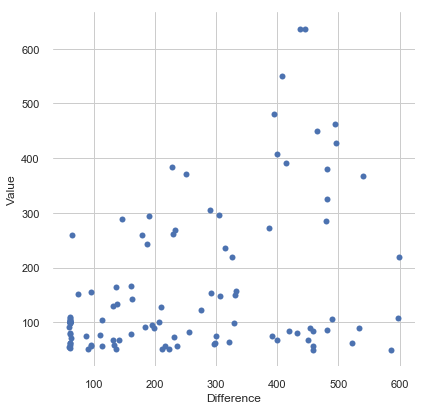

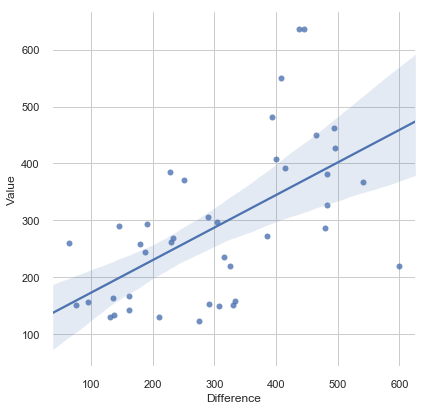

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="Difference", y="Value",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=df_cleaned, ax=ax)


f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.regplot(x="Difference", y="Value",
                data=df_cleaned[df_cleaned['Value']>120], ax=ax)


1. На первый взгляд никакой линейной зависимости в данных нет, но это обусловленно тем что для каждого временного интервала от 100 до 600 секунд у нас присутсвуют значения менше 100 шагов. Не совсем понятно, как это интерпретировать не зная устройство работы трекера. Если это шум в данных вызванный некорректной работой трекера, то отсекая его мы получаем почти линейную зависимость в данных (пример на графике).

In [172]:
import sklearn.linear_model as lm
x=df_cleaned[df_cleaned['Value']>120]['Difference'].values.reshape((-1, 1))
y=df_cleaned[df_cleaned['Value']>120]['Value'].values
# create an empty model
skm = lm.LinearRegression()
# calculate parameters
skm.fit(x, y)
# show them
skm.intercept_, skm.coef_

(115.1200894668062, array([0.57290695]))

In [173]:
r_sq = skm.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.34409763553598155


#### 1.2.2.Временной ряд для среднего значения количества шагов по каждому дню недели

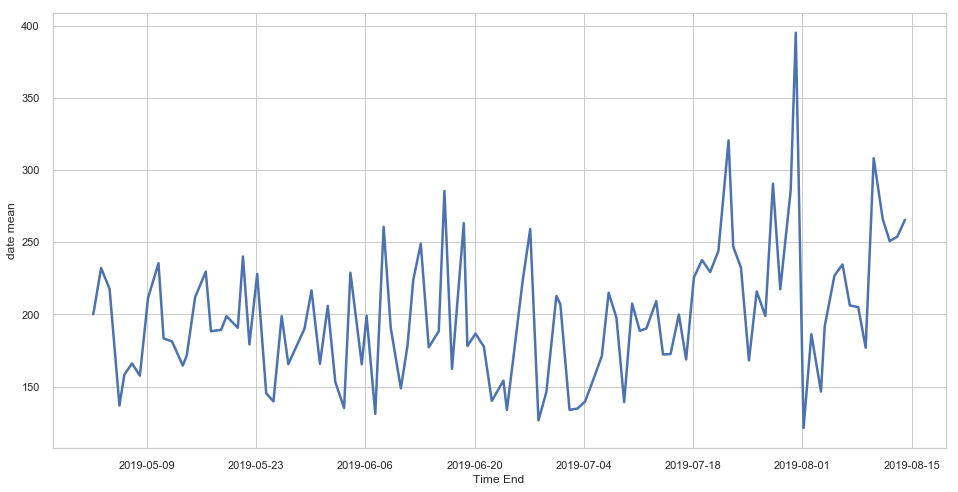

In [174]:
fig, ax = plt.subplots(figsize=(16,8)) 
sns.lineplot(x='Time End',
    y='date mean',
    data=df_cleaned, palette="tab10", linewidth=2.5)

1. Временной ряд не стационарен, ярко выраженной цикличности не наблюдается, возможен тренд дисперсии после 2019-07-04. Требуется отдельная работа для анализа такого временного ряда, поэтому остановимся на этом.

#### 1.2.3. Boxplot для среднего значения количества шагов по каждому дню недели

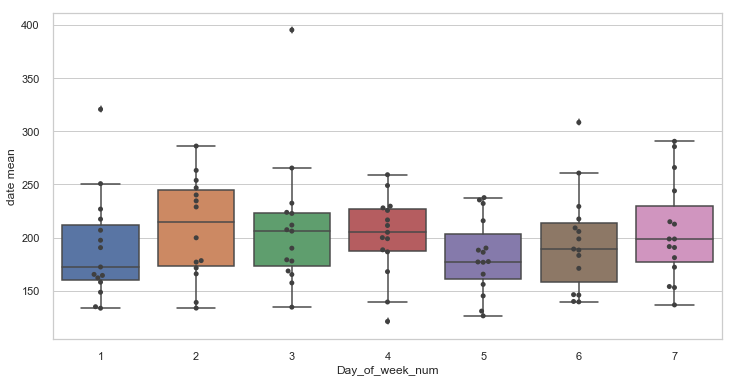

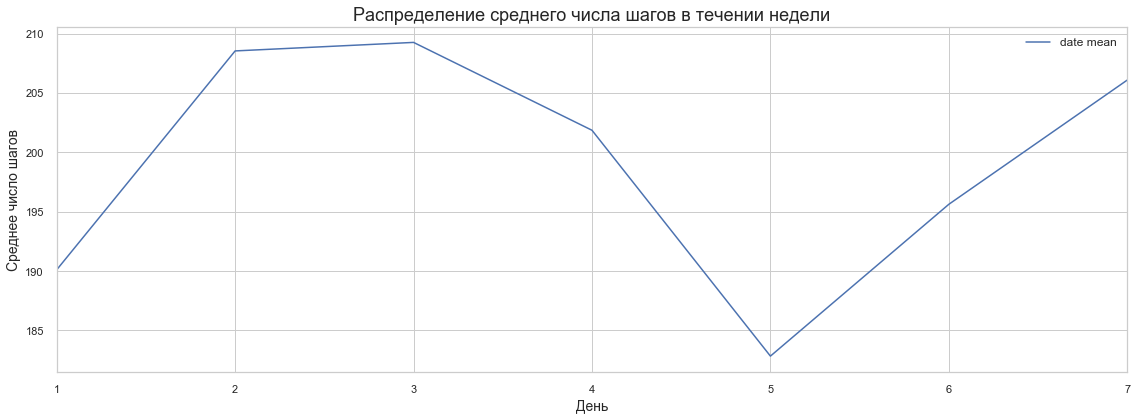

In [175]:
fig, ax = plt.subplots(figsize=(12,6)) 
ax = sns.boxplot(
    x='Day_of_week_num',
    y='date mean',
    data=df_cleaned)

ax = sns.swarmplot(
    x='Day_of_week_num',
    y='date mean',
    data=df_cleaned,
    color=".25")


pd.DataFrame(df_cleaned.groupby('Day_of_week_num')['date mean'].mean()).plot(figsize=(16,6))

plt.title('Распределение среднего числа шагов в течении недели', fontsize=18)
plt.xlabel('День', fontsize=14)
plt.ylabel('Среднее число шагов', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [176]:
pd.DataFrame(df_cleaned.groupby('Day_of_week_num')['date mean'].mean())

date mean
Day_of_week_num            
1                190.107726
2                208.545706
3                209.263146
4                201.861859
5                182.835545
6                195.626325
7                206.092611

### Как видно очистка данных и работа с признаками принесла свои результаты:

1. Среднее значение шагов для любого дня недели колеблется в диапозоне 200 плюс-минус 10 шагов.
2. Стала видна динамика роста среднего числа шагов в течении недели.Пик активности приходиться на вторник и среду, пятница-"день отдыха" и постепенное увеличение активности к воскресенью. Я бы сказал типичная картина, которая довольно корректно отображает среднестатистического жителя мегаполиса.
3. Сохраним в виде словаря наши среднее значения по дням и будем использовать их как "rule-based model" для принятия решения является ли день аномальным или же он является обыкновенным.Будем пользоваться эвристикой "трех сигм" для разметки наших дней недели. Если разница между средним нашего наблюдаемого дня и средним котороые мы выбрали в качестве оценки составляет более 6 стандартных отклонений(так как мы ищем именно аномальные(экстремальные значения)), то мы помечаем такой день как "аномальный", если же нет то такой день помечается как обычный.

In [196]:
df_dict = pd.DataFrame(df_cleaned.groupby('Day_of_week_num')['date mean'].mean()).T.to_dict('list')
three_sigma = pd.DataFrame(df_cleaned.groupby('Day_of_week_num')['date mean'].mean()).std()[0]*6
df_cleaned['Baseline'] = df_cleaned['Day_of_week_num'].replace(df_dict)
df_cleaned['Deviation'] = abs(df_cleaned['Baseline']-df_cleaned['date mean'])
df_cleaned['Mapped_day'] = df_cleaned['Deviation'].apply(lambda x: 'Обычный день' if x < three_sigma else 'Аномальный день')

In [200]:
df_cleaned[df_cleaned['Mapped_day'] == 'Аномальный день']

Time End  Time Offset  User ID  \
Time Start                                                                  
2019-05-05 14:58:09+03:00 2019-05-05 14:59:59+03:00        10800     2166   
2019-07-22 16:09:17+03:00 2019-07-22 16:16:51+03:00        10800     2166   
2019-07-30 15:18:23+03:00 2019-07-30 15:25:11+03:00        10800     2166   
2019-07-04 06:50:00+03:00 2019-07-04 06:54:58+03:00         7200     2166   
2019-06-16 06:20:00+03:00 2019-06-16 06:27:17+03:00        10800     2166   
2019-07-28 08:45:32+03:00 2019-07-28 08:50:53+03:00        10800     2166   
2019-06-08 11:27:41+03:00 2019-06-08 11:29:59+03:00        10800     2166   
2019-08-12 07:51:21+03:00 2019-08-12 07:54:29+03:00        10800     2166   
2019-07-31 06:57:47+03:00 2019-07-31 07:02:03+03:00        10800     2166   
2019-07-03 07:10:00+03:00 2019-07-03 07:11:31+03:00         7200     2166   
2019-08-10 06:31:46+03:00 2019-08-10 06:40:00+03:00        10800     2166   
2019-07-09 07:13:41+03:00 2019-07-09 07:15:16+03:00        10800     2166   
2019-07-02 07:12:36+03:00 2019-07-02 07:13:39+03:00         7200     2166   
2019-08-01 06:51:54+03:00 2019-08-01 06:58:54+03:00        10800     2166   

                           Value  Difference  year month date hour  \
Time Start                                                           
2019-05-05 14:58:09+03:00     77       110.0  2019   May   05   14   
2019-07-22 16:09:17+03:00     89       454.0  2019   Jul   22   16   
2019-07-30 15:18:23+03:00    550       408.0  2019   Jul   30   15   
2019-07-04 06:50:00+03:00     62       298.0  2019   Jul   04   06   
2019-06-16 06:20:00+03:00    636       437.0  2019   Jun   16   06   
2019-07-28 08:45:32+03:00     65       321.0  2019   Jul   28   08   
2019-06-08 11:27:41+03:00    134       138.0  2019   Jun   08   11   
2019-08-12 07:51:21+03:00    244       188.0  2019   Aug   12   07   
2019-07-31 06:57:47+03:00     83       256.0  2019   Jul   31   06   
2019-07-03 07:10:00+03:00     52        91.0  2019   Jul   03   07   
2019-08-10 06:31:46+03:00    463       494.0  2019   Aug   10   06   
2019-07-09 07:13:41+03:00     59        95.0  2019   Jul   09   07   
2019-07-02 07:12:36+03:00     72        63.0  2019   Jul   02   07   
2019-08-01 06:51:54+03:00     85       420.0  2019   Aug   01   06   

                          Day_of_week  Day_of_week_num  num_of_observations  \
Time Start                                                                    
2019-05-05 14:58:09+03:00         Sun                7                    5   
2019-07-22 16:09:17+03:00         Mon                1                   53   
2019-07-30 15:18:23+03:00         Tue                2                  100   
2019-07-04 06:50:00+03:00         Thu                4                  634   
2019-06-16 06:20:00+03:00         Sun                7                 1277   
2019-07-28 08:45:32+03:00         Sun                7                 2193   
2019-06-08 11:27:41+03:00         Sat                6                 3200   
2019-08-12 07:51:21+03:00         Mon                1                 4500   
2019-07-31 06:57:47+03:00         Wed                3                 7481   
2019-07-03 07:10:00+03:00         Wed                3                18233   
2019-08-10 06:31:46+03:00         Sat                6                18555   
2019-07-09 07:13:41+03:00         Tue                2                28692   
2019-07-02 07:12:36+03:00         Tue                2                29525   
2019-08-01 06:51:54+03:00         Thu                4                29882   

                          date + hour date + month   hour mean   date mean  \
Time Start                                                                   
2019-05-05 14:58:09+03:00     05 + 14     05 + May  195.700000  136.857143   
2019-07-22 16:09:17+03:00     22 + 16     22 + Jul  106.200000  320.515152   
2019-07-30 15:18:23+03:00     30 + 15     30 + Jul  502.000000  286.062500   
2019-07-04 06:50:00+03:00     04 +

# 2. Вся модель в виде 1 класса

Задача звучит так - создать функцию на языке Python, которая для конкретного пользователя берет его историю шагов и на выходе  отдает список размеченных дней: неизвестно, обычный или необычный.

Ваша цель - максимально попасть в субъективное ощущение пользователя, чтобы он согласился с вашим мнением о том, что сегодня он прошел 10 000 шагов и это необычно. Или сегодня он прошел 6 000 шагов и в этом нет ничего необычного.


In [200]:
df=pd.read_csv('./query_result_2019-12-24T07_29_06.659397Z.csv', engine = 'python', sep="," , encoding = 'utf-8'
                       )

In [201]:
class Fit_report(object):
    def __init__(self, min_time=10, max_time=1000 , min_steps=50):
        self.min_time = min_time
        self.max_time = max_time
        self.min_steps = min_steps

    def preprocesing(self,df):
        
        df['Time End'] = pd.to_datetime(df['Time End'], infer_datetime_format=True, dayfirst=True)
        df['Time Start'] = pd.to_datetime(df['Time Start'], infer_datetime_format=True, dayfirst=True)
        df['Difference'] = df['Time End'] - df['Time Start']
        df['Difference'] = df['Difference'] / np.timedelta64(1, 's')
        df.set_index('Time Start', inplace=True)
        df.drop(['Time End Local Tz', 'Time Start Local Tz'], axis=1, inplace=True)
        df['year'] = df.index.strftime('%Y')
        df['month'] = df.index.strftime('%b')
        df['date'] = df.index.strftime('%d')
        df['hour'] = df.index.strftime('%H')
        df['Day_of_week'] = df.index.strftime('%a')
        df['Day_of_week_num'] = df.index.strftime('%u')
        df['Day_of_week_num'] = df['Day_of_week_num'].astype(int)
        df['Value']=df['Value'].astype(int)
        df['num_of_observations']=np.arange(len(df))

        self.preprocesed_df = df
    
        return 
    
    def fit(self):
        
        self.df_fitted = self.preprocesed_df[(self.preprocesed_df["Difference"]<self.max_time)&(self.preprocesed_df["Value"]>self.min_steps)&(self.preprocesed_df["Difference"]>self.min_time)]
        self._make_conj(self.df_fitted, 'date', 'month')
        self.df_fitted['date mean'] = self._code_mean(self.df_fitted, 'date + month', 'Value')
        self.df_fitted['Число шагов за день'] = self._code_sum(self.df_fitted, 'date + month', 'Value')
        self.df_fitted['Среднее число шагов в этот день недели'] = self._code_sum(self.df_fitted, 'Day_of_week_num', 'Value')
        self.df_fitted['Среднее число шагов в этот день недели'] = self.df_fitted['Среднее число шагов в этот день недели'].apply(lambda x: x/15).astype(int)
        self.df_fitted = self.df_fitted.drop_duplicates(subset=['date + month'], keep='first', inplace=False)
        
        return self.df_fitted

    def predict(self):
        df_preds = self.df_fitted
        df_dict = pd.DataFrame(df_preds.groupby('Day_of_week_num')['date mean'].mean()).T.to_dict('list')
        three_sigma = pd.DataFrame(df_preds.groupby('Day_of_week_num')['date mean'].mean()).std()[0]*6
        df_preds['Baseline'] = df_preds['Day_of_week_num'].replace(df_dict)
        df_preds['Deviation'] = abs(df_preds['Baseline']-df_preds['date mean'])
        df_preds['Mapped_day'] = df_preds['Deviation'].apply(lambda x: 'Обычный день' if x < three_sigma else 'Аномальный день')
        
        self.df_preds = df_preds
        
        return df_preds
    
    def report(self,df_report):
        
        df_report.set_index('User ID', inplace=True)
        df_report = df_report.iloc[:,11:18]
        df_report.drop(['date mean', 'Deviation', 'Baseline'], axis=1, inplace=True)
        
        
        fig, ax = plt.subplots(figsize=(12,6)) 
        ax = sb.scatterplot(x="Day_of_week_num", y="Число шагов за день", hue="Mapped_day",
                         data=self.df_preds)
        
        ax.set_title('Распределение аномальных значений по дням недели в зависимости от числа шагов за день')
        ax.set_xlabel('День недели')
        
                
        fig, ax = plt.subplots(figsize=(12,6)) 
        ax = sb.scatterplot(x="Day_of_week_num", y="date mean", hue="Mapped_day",
                         data=self.df_preds)
        
        
        ax.set_title('Распределение аномальных значений по дням недели в зависимости от оценки активности пользователя')
        ax.set_xlabel('День недели')
        
        fig, ax = plt.subplots(figsize=(12,6)) 
        ax = sb.scatterplot(x="date + month", y="Число шагов за день", 
                         data=self.df_preds[self.df_preds['Mapped_day']=='Аномальный день'])
        
        
        ax.set_title('Распределение и величина аномальных значений за все время')
        ax.set_xlabel('Число и месяц')


        return df_report
    

    def _make_conj(self, data, feature1, feature2):
        data[feature1 + ' + ' + feature2] = data[feature1].astype(str) + ' + ' + data[feature2].astype(str)
        return (data)

    def _code_mean(self, data, cat_feature, real_feature):
        return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))
    
    def _code_sum(self, data, cat_feature, real_feature):
        return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].sum()))    

In [202]:
model = Fit_report(min_time=59, max_time = 600,  min_steps=49)

In [203]:
model.preprocesing(df)

In [204]:
fitted=model.fit()

In [205]:
predicted

Time End  Time Offset  Value  Difference  year month  \
User ID                                                                         
2166    2019-05-05 14:59:59+03:00        10800     77       110.0  2019   May   
2166    2019-06-05 16:16:28+03:00        10800    100        61.0  2019   Jun   
2166    2019-07-16 07:31:12+03:00        10800     63        61.0  2019   Jul   
2166    2019-06-23 19:59:59+03:00        10800    368       541.0  2019   Jun   
2166    2019-07-22 16:16:51+03:00        10800     89       454.0  2019   Jul   
...                           ...          ...    ...         ...   ...   ...   
2166    2019-06-13 05:43:36+03:00        10800     57       216.0  2019   Jun   
2166    2019-05-25 08:39:59+03:00        10800     55        60.0  2019   May   
2166    2019-07-24 06:24:29+03:00        10800    408       400.0  2019   Jul   
2166    2019-06-02 06:55:07+03:00        10800    149       307.0  2019   Jun   
2166    2019-06-28 07:44:19+03:00        10800    100       207.0  2019   Jun   

        date hour Day_of_week  Day_of_week_num  num_of_observations  \
User ID                                                               
2166      05   14         Sun                7                    5   
2166      05   16         Wed                3                   21   
2166      16   07         Tue                2                   34   
2166      23   19         Sun                7                   44   
2166      22   16         Mon                1                   53   
...      ...  ...         ...              ...                  ...   
2166      13   05         Thu                4                35088   
2166      25   08         Sat                6                35418   
2166      24   06         Wed                3                36831   
2166      02   06         Sun                7                38695   
2166      28   07         Fri                5                39024   

        date + month   date mean  Число шагов за день  \
User ID                                                 
2166        05 + May  136.857143                 4790   
2166        05 + Jun  165.421053                 6286   
2166        16 + Jul  199.896552                 5797   
2166        23 + Jun  154.136364                 6782   
2166        22 + Jul  320.515152                10577   
...              ...         ...                  ...   
2166        13 + Jun  248.965517                 7220   
2166        25 + May  139.718750                 4471   
2166        24 + Jul  232.416667                 5578   
2166        02 + Jun  153.194444                 5515   
2166        28 + Jun  126.575758                 4177   

         Среднее число шагов в этот день недели    Baseline   Deviation  \
User ID                                                                   
2166                                       6781  206.092611   69.235468   
2166                                       7273  209.263146   43.842093   
2166                                       6614  208.545706    8.649155   
2166                                       6781  206.092611   51.956248   
2166                                       5812  190.107726  130.407426   
...                                         ...         ...         ...   
2166                                       6616  201.861859   47.103658   
2166                                       5989  195.626325   55.907575   
2166                                       7273  209.263146   23.153521   
2166                                       6781  206.092611   52.898167   
2166                                       5685  182.835545   56.259787   

              Mapped_day  
User ID                   
2166     Аномальный день  
2166        Обычный день  
2166        Обычный день  
2166        Обычный день  
2166     Аномальный день  
...                  ...  
2166        Обычный день  
2166        Обычный день  
2166        Обычный день  
2166        Обычный день  
2166 

In [206]:
predicted=model.predict()

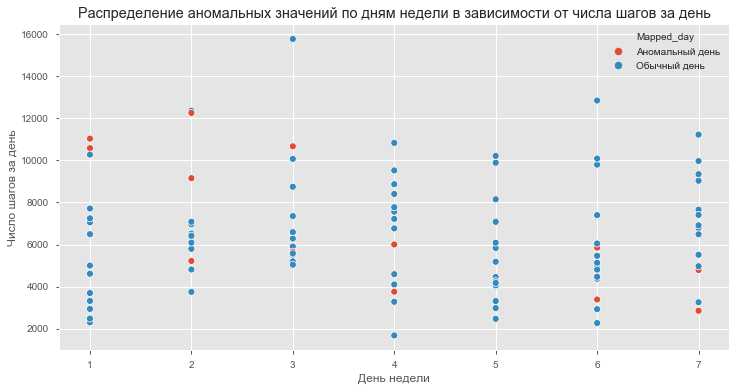

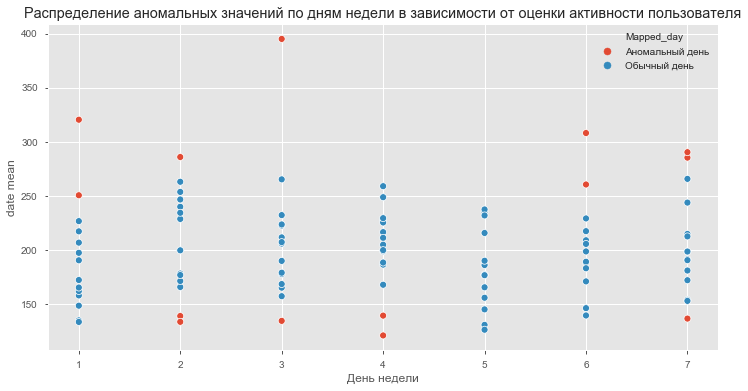

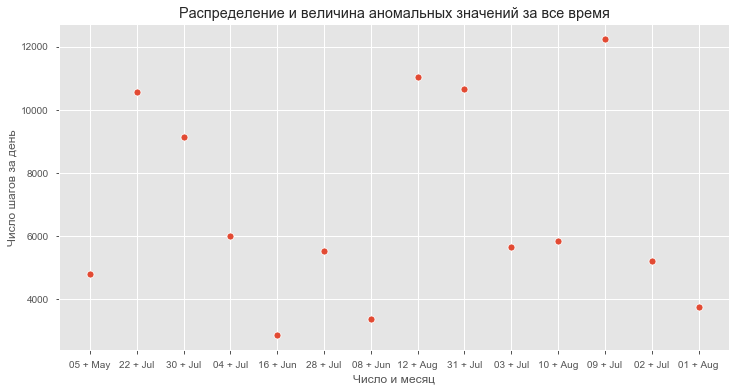

In [207]:
df_report = model.report(predicted)

#### Выводы на основе визуализации:
1. Есть очевидные точки которые выглядят как выбросы и алгоритм улавливает их как выбросы (воскресенье, понедельник, вторник). Это одни из экстремальных значений за весь период, однако что делать например с 3 точкой во вторник и точками в четверг,пятницу и субботу?Если бы использовали как оценку среднее число шагов, то эти точки должныы были бы попасть в диапозон нормальных.Однако поскольку мы используем в качетсве оценки среднее значение "активности" пользователя по дням недели (с учетом фильтрации и обработки данных), то на втором графике видно что все аномальные значения являются либо минимальными либо максимальными значениями для выбранного дня недели.
2. Это говорит о том что наибольшие или наименьшие суммы движений для выбранного дня, могут быть обусловленны большим количеством действий в течении дня, и итоговое значение таким образом не будет ощущаться пользователем как "экстраординарное". Таким образом гораздо важнее отслеживать количество и "энергетику" действий пользователя по дням, чем мониторить его "пики" активности.

In [169]:
df_report.head(50)

date + month  Число шагов за день  \
User ID                                     
2166        05 + May                 4790   
2166        05 + Jun                 6286   
2166        16 + Jul                 5797   
2166        23 + Jun                 6782   
2166        22 + Jul                10577   
2166        30 + Jul                 9154   
2166        17 + Jul                 5906   
2166        14 + Aug                 5574   
2166        21 + May                 6483   
2166        07 + Jul                 9030   
2166        11 + Aug                 6913   
2166        29 + Jun                 4968   
2166        20 + May                 7055   
2166        04 + Jul                 6003   
2166        29 + May                 8746   
2166        07 + Jun                 4456   
2166        15 + Jun                 9796   
2166        21 + Jul                11223   
2166        05 + Jul                 4059   
2166        10 + Jun                 4612   
2166        16 + Jun                 2855   
2166        03 + Jun                 2433   
2166        18 + Jun                 6317   
2166        10 + May                 9888   
2166        30 + May                 8884   
2166        24 + May                 2471   
2166        28 + Jul                 5520   
2166        08 + Jun                 3389   
2166        17 + May                 5837   
2166        12 + May                 9969   
2166        12 + Aug                11033   
2166        23 + May                 4104   
2166        30 + Jun                 7659   
2166        19 + Jul                 7129   
2166        06 + Jun                 7564   
2166        09 + May                 6766   
2166        05 + Aug                 7713   
2166        15 + May                 5508   
2166        27 + Jul                 4375   
2166        25 + Jul                 1681   
2166        26 + Jul                 5182   
2166        13 + May                 2304   
2166        13 + Jul                 4811   
2166        31 + Jul                10668   
2166        06 + May                 3323   
2166        18 + May                 2272   
2166        18 + Jul                10829   
2166        08 + Aug                 3281   
2166        20 + Jun                 9522   
2166        11 + Jun                 6960   

         Среднее число шагов в этот день недели       Mapped_day  
User ID                                                           
2166                                       6781  Аномальный день  
2166                                       7273     Обычный день  
2166                                       6614     Обычный день  
2166                                       6781     Обычный день  
2166                                       5812  Аномальный день  
2166                                       6614  Аномальный день  
2166                                       7273     Обычный день  
2166                                       7273     Обычный день  
2166                                       6614     Обычный день  
2166                                       6781     Обычный день  
2166                                       6781     Обычный день  
2166                                       5989     Обычный день  
2166                                       5812     Обычный день  
2166                                       6616  Аномальный день  
2166                                       7273     Обычный день  
2166                                       5685     Обычный день  
2166                                       5989     Обычный день  
2166                                       6781     Обычный день  
2166                                       5685     Обычный день  
2166                                       5812     Обычный день  
2166                                       6781  Аномальный день  
2166                                       5812     Обычный день  
2166                                       6614     Обычный

#### Выводы:
1. Считаю задачу выполненной. Есть класс который на вход принимает только 3 параметра и обратно выводит размеченные дни пользователя. Для того чтобы эти параметры "зашить" внутрь модели, требуется больше данных и впринципе работа над этим конкретным устройством.
2. Наиболее приемлемыми инструментами для решения задачи прогнозирования количества шагов (следовательно активности пользователя), а так же обратной задачи, которую можно интерпретировать как задачу мультиномиальной классификации (одного из 7 дней недели по количеству шагов и другим признакам) мне представляются деревья решений (в том числе и регрессионные), а так же различные виды линейных классификаторов с различными видами регуляризации . Задача определенно требует больше данных и времении для создания полноценной рекомендательной системы.